# Amazon Title Reviews Sentiment - Bidirectional LSTM

In [14]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
sns.set_style("darkgrid")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re, string, nltk
import emoji, bz2
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../input/amazonn-reviews/Amazon_review.csv")
df.head()

,Unnamed: 0,review,sentiment
0,1959029,I just adopted a chocolate lab who loves to sn...,1
1,971879,Watched it and wasn't very impressed. It was t...,0
2,44681,"By 1967, enough was enough with the light fluf...",0
3,793119,I was interested in what all the hype was abou...,0
4,2921599,I expected a well written book (as someone rec...,0


In [4]:
df = df[["review","sentiment"]]
df

,review,sentiment
0,I just adopted a chocolate lab who loves to sn...,1
1,Watched it and wasn't very impressed. It was t...,0
2,"By 1967, enough was enough with the light fluf...",0
3,I was interested in what all the hype was abou...,0
4,I expected a well written book (as someone rec...,0
...,...,...
100795,I purchased this product for my 1 year old twi...,0
100796,"When reading this book, you will probably find...",1
100797,This video has some really great tunes the muc...,1
100798,"I did finish the movie, but it was only rallyi...",0


In [5]:
# shape of data
print(f"Data consists of {df.shape[0]} rows and {df.shape[1]} columns.")

Data consists of 100800 rows and 2 columns.


In [6]:
# checking for null values
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
# dropping null values
df = df.dropna()

In [7]:
# checking for any duplicate in the data
df.duplicated().sum()

4

In [8]:
df1 = df
df1.shape

(100800, 2)

In [9]:
df1.sentiment.value_counts()

1    50515
0    50285
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Countplot for Sentiment Labels')

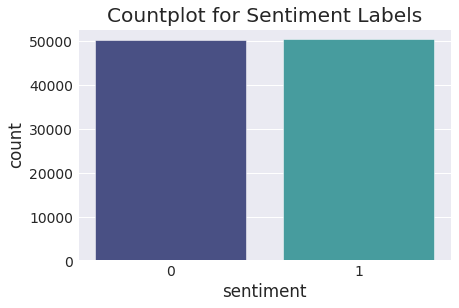

In [15]:
sns.countplot(df1.sentiment,palette="mako")
plt.title("Countplot for Sentiment Labels")

* Classes are balanced. So, no need for oversampling or undersampling the target column.

# Cleaning Data

In [18]:
def clean_text(df, field):
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.replace("#[^a-zA-Z0-9_]+"," ")
    df[field] = df[field].str.replace(r"[^a-zA-Z(),\"'\n_]"," ")
    df[field] = df[field].str.replace(r"http\S+","")
    df[field] = df[field].str.lower()
    return df

clean_text(df1,"review")

,review,sentiment
0,i just adopted a chocolate lab who loves to sn...,1
1,watched it and wasn't very impressed it was t...,0
2,"by , enough was enough with the light fluf...",0
3,i was interested in what all the hype was abou...,0
4,i expected a well written book (as someone rec...,0
...,...,...
100795,i purchased this product for my year old twi...,0
100796,"when reading this book, you will probably find...",1
100797,this video has some really great tunes the muc...,1
100798,"i did finish the movie, but it was only rallyi...",0


In [19]:
# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    text= re.sub(emoji.get_emoji_regexp(),"",text)
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

df1["clean_review"] = df1["review"].apply(preprocess_text)

In [20]:
df1.head(15)

,review,sentiment,clean_review
0,i just adopted a chocolate lab who loves to sn...,1,adopted chocolate lab love snuggle rub furnitu...
1,watched it and wasn't very impressed it was t...,0,watched impressed taken min le tv show called ...
2,"by , enough was enough with the light fluf...",0,enough enough light fluff comedy starring elvi...
3,i was interested in what all the hype was abou...,0,interested hype like book nicely banded pretty...
4,i expected a well written book (as someone rec...,0,expected well written book someone recommended...
5,this is a great little feeder for a window si...,1,great little feeder window simple basic design...
6,i know that everyone thinks that the exorcist ...,0,know everyone think exorcist best film ever ma...
7,twp of my favorite stars clair danes and je...,0,twp favorite star clair dane jennifer lopez to...
8,this item was ordered for me as a birthday gif...,0,item ordered birthday gift june september stil...
9,"the product was shipped in good time, but i wa...",0,product shipped good time dissappointed tea re...


Text(0, 0.5, 'Text Length')

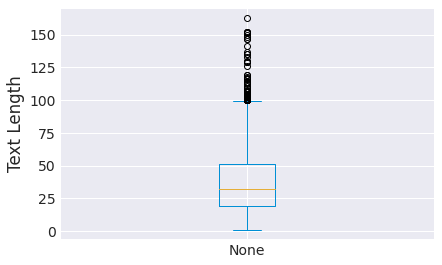

In [21]:
text_length = pd.Series([len(review.split()) for review in df1["clean_review"]])
text_length.plot(kind="box")
plt.ylabel("Text Length")

Text(0, 0.5, 'Frequency')

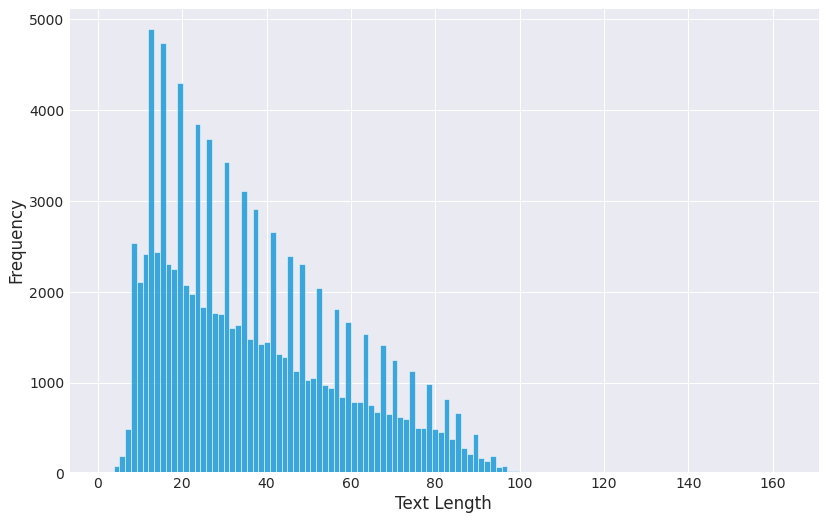

In [23]:
plt.figure(figsize=(12,8))
sns.histplot(text_length,palette="deep")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

### WordClouds
* Useful for viewing and analyzing words that are frequently used.

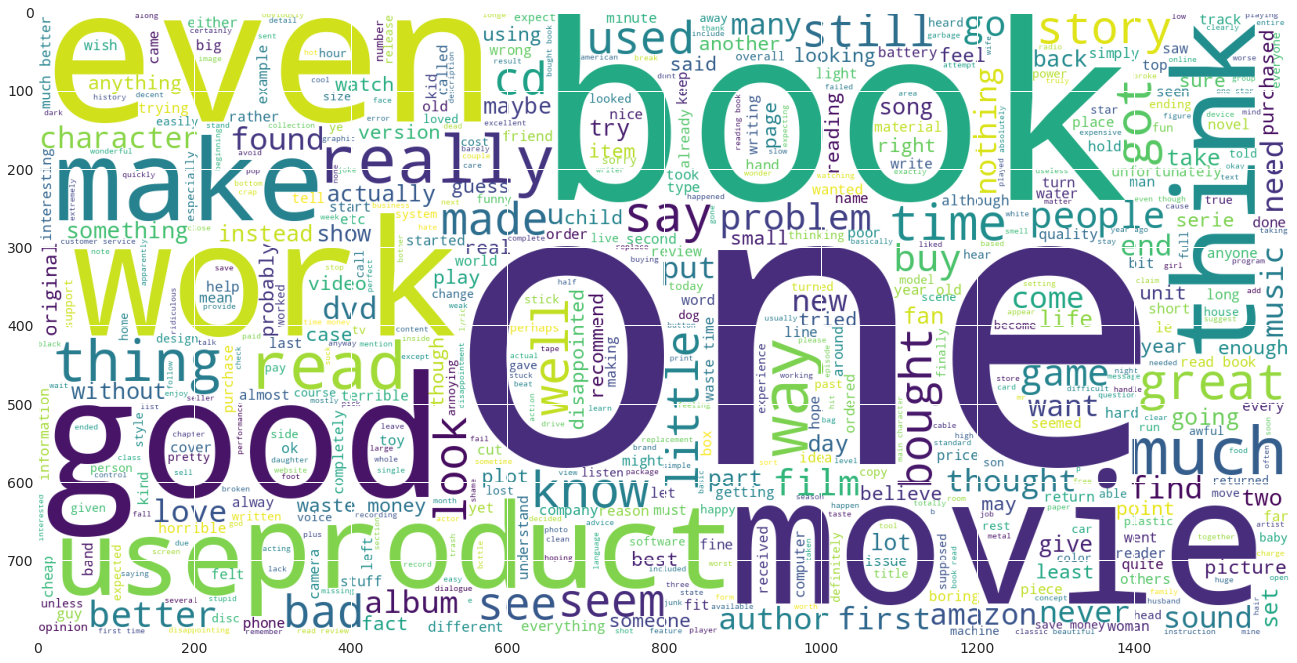

In [58]:
# Negative Review WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(df[df["sentiment"]==0].clean_review))
plt.imshow(wc1)

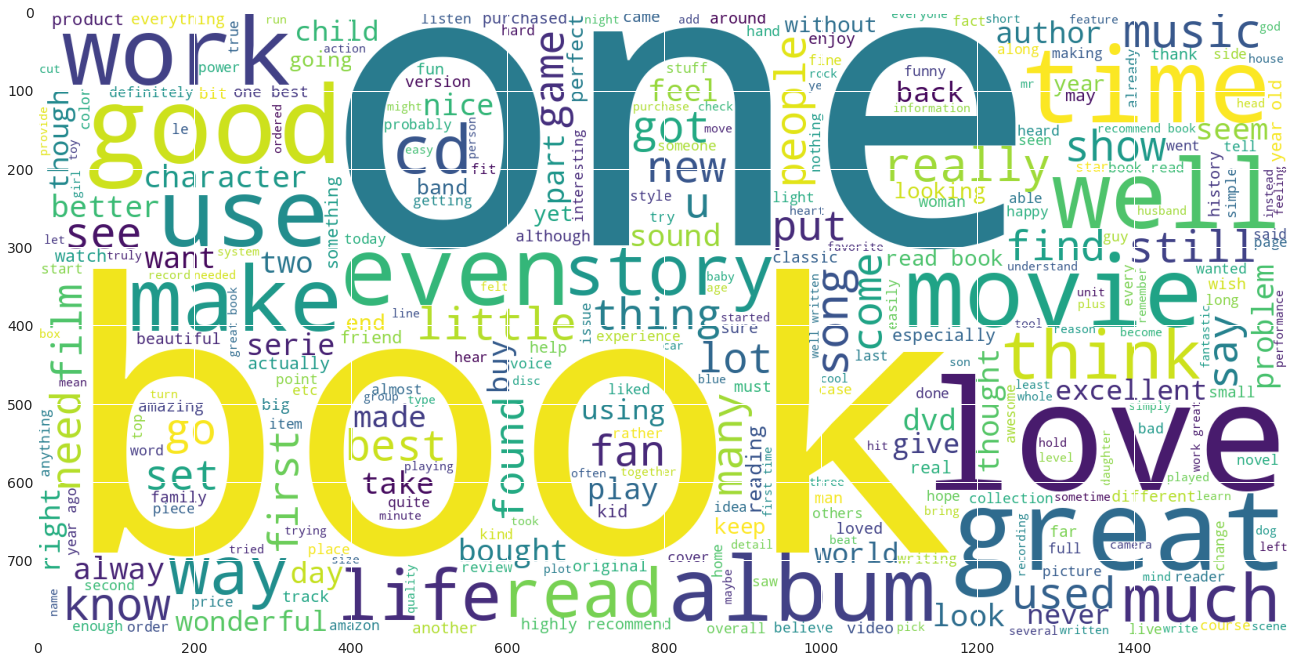

In [57]:
# Positive Review WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(df[df["sentiment"]==1].clean_review))
plt.imshow(wc)

In [24]:
df = df1[["sentiment","clean_review"]]
df.head(10)

,sentiment,clean_review
0,1,adopted chocolate lab love snuggle rub furnitu...
1,0,watched impressed taken min le tv show called ...
2,0,enough enough light fluff comedy starring elvi...
3,0,interested hype like book nicely banded pretty...
4,0,expected well written book someone recommended...
5,1,great little feeder window simple basic design...
6,0,know everyone think exorcist best film ever ma...
7,0,twp favorite star clair dane jennifer lopez to...
8,0,item ordered birthday gift june september stil...
9,0,product shipped good time dissappointed tea re...


In [25]:
df.sentiment.unique()

array([1, 0])

# Model Training

In [26]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["clean_review"]),np.array(df["sentiment"]), test_size=0.25,random_state=42)
print(X_train.shape)
print(X_test.shape)

(75600,)
(25200,)


### Term Frequency- Inverse Document Frequency (TF-IDF)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
X_train_tf2 = tfidf2.fit_transform(X_train)
X_test_tf2 = tfidf2.transform(X_test)

#### Fitting Machine learning Models

In [28]:
rf = RandomForestClassifier()
rf.fit(X_train_tf2, y_train)

RandomForestClassifier()

In [29]:
from sklearn.metrics import roc_auc_score
y_pred = rf.predict(X_test_tf2)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_test, y_pred)
roc = roc_auc_score(y_test,y_pred)
print(f"Accuracy: {acc*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred)}")
print(report)

Accuracy: 83.37301587301587% and Roc Auc Score:0.833707143620021
              precision    recall  f1-score   support

           0       0.82      0.85      0.84     12618
           1       0.84      0.82      0.83     12582

    accuracy                           0.83     25200
   macro avg       0.83      0.83      0.83     25200
weighted avg       0.83      0.83      0.83     25200



In [30]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
xgb = XGBClassifier(eval_metric="mlogloss")
xgb.fit(X_train_tf2, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
y_pred2 = xgb.predict(X_test_tf2)
acc2 = accuracy_score(y_pred2, y_test)
report2 = classification_report(y_test, y_pred2)
roc2 = roc_auc_score(y_test,y_pred2)
print(f"Accuracy: {acc2*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred2)}")
print(report2)

Accuracy: 82.45238095238095% and Roc Auc Score:0.8245245851975661
              precision    recall  f1-score   support

           0       0.83      0.82      0.82     12618
           1       0.82      0.83      0.82     12582

    accuracy                           0.82     25200
   macro avg       0.82      0.82      0.82     25200
weighted avg       0.82      0.82      0.82     25200



In [32]:
lgb = LGBMClassifier()
lgb.fit(X_train_tf2, y_train)

LGBMClassifier()

In [33]:
y_pred_lgb = lgb.predict(X_test_tf2)
acc_lgb = accuracy_score(y_pred_lgb, y_test)
report_lgb = classification_report(y_test, y_pred_lgb)
roc_lgb = roc_auc_score(y_test,y_pred_lgb)
print(f"Accuracy: {acc_lgb*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred_lgb)}")
print(report_lgb)

Accuracy: 83.17857142857143% and Roc Auc Score:0.8318015274861105
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12618
           1       0.82      0.84      0.83     12582

    accuracy                           0.83     25200
   macro avg       0.83      0.83      0.83     25200
weighted avg       0.83      0.83      0.83     25200



In [34]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tf2, y_train)

MultinomialNB()

In [35]:
y_pred3 = nb.predict(X_test_tf2)
acc3 = accuracy_score(y_pred3, y_test)
report3 = classification_report(y_test, y_pred3)
roc3 = roc_auc_score(y_test,y_pred3)
print(f"Accuracy: {acc3*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred3)}")
print(report3)

Accuracy: 81.98809523809524% and Roc Auc Score:0.8198564917706181
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     12618
           1       0.83      0.80      0.82     12582

    accuracy                           0.82     25200
   macro avg       0.82      0.82      0.82     25200
weighted avg       0.82      0.82      0.82     25200



In [36]:
gb = GradientBoostingClassifier()
gb.fit(X_train_tf2, y_train)

GradientBoostingClassifier()

In [37]:
y_pred4 = gb.predict(X_test_tf2)
acc4 = accuracy_score(y_pred4, y_test)
report4 = classification_report(y_test, y_pred4)
roc4 = roc_auc_score(y_test,y_pred4)
print(f"Accuracy: {acc4*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred4)}")
print(report4)

Accuracy: 76.20238095238095% and Roc Auc Score:0.7619466230203191
              precision    recall  f1-score   support

           0       0.74      0.82      0.77     12618
           1       0.79      0.71      0.75     12582

    accuracy                           0.76     25200
   macro avg       0.77      0.76      0.76     25200
weighted avg       0.77      0.76      0.76     25200



In [38]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tf2, y_train)
y_pred5 = dt.predict(X_test_tf2)
acc5 = accuracy_score(y_pred5, y_test)
report5 = classification_report(y_test, y_pred5)
roc5 = roc_auc_score(y_test,y_pred5)
print(f"Accuracy: {acc5*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred5)}")
print(report5)

Accuracy: 70.85714285714285% and Roc Auc Score:0.7085760492481732
              precision    recall  f1-score   support

           0       0.71      0.71      0.71     12618
           1       0.71      0.71      0.71     12582

    accuracy                           0.71     25200
   macro avg       0.71      0.71      0.71     25200
weighted avg       0.71      0.71      0.71     25200



In [39]:
from sklearn.metrics import precision_score
ps = precision_score(y_test, y_pred)
ps_lgb = precision_score(y_test,y_pred_lgb)
ps2 = precision_score(y_test, y_pred2)
ps3 = precision_score(y_test, y_pred3)
ps4 = precision_score(y_test, y_pred4)
ps5 = precision_score(y_pred5,y_test)

In [40]:
accuracys = [acc,acc2,acc3,acc4,acc5,acc_lgb]
roc_scores = [roc, roc2, roc3, roc4,roc5, roc_lgb]
precision_scores = [ps,ps2,ps3,ps4,ps5,ps_lgb]
models = {"Random Forest":rf,"XGboost":xgb,"Naive Bayes":nb,"Gradient Boosting":gb,"Decision Tree":dt,"LGB Machine":lgb}

model_df = pd.DataFrame({"Models":models.keys(),"Accuracy":accuracys,"Precision Score":precision_scores,"Roc Scores": roc_scores}).sort_values("Roc Scores",ascending=False)

In [41]:
# Summary of Machine Learning Models Performance
model_df

,Models,Accuracy,Precision Score,Roc Scores
0,Random Forest,0.833730,0.844443,0.833707
5,LGB Machine,0.831786,0.824201,0.831802
1,XGboost,0.824524,0.823758,0.824525
2,Naive Bayes,0.819881,0.830797,0.819856
3,Gradient Boosting,0.762024,0.793214,0.761947
4,Decision Tree,0.708571,0.711811,0.708576


# Deep Learning
* Applying tokenizer for Bi-LSTM input after splitting data into training and testing/validation set.

In [42]:
from sklearn.model_selection import train_test_split
X = df["clean_review"]
y = df.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
display(X_train.shape)
display(X_test.shape)

(75600,)

(25200,)

In [43]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [44]:
# using tokenizer to transform text messages into training and testing set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [45]:
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=64)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=64)

In [46]:
X_train_seq_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     8,   243,     1,   137,    32,  2616, 25920,
          39,    66,   195,    98,    15,  1916,  2840,    98,    15,
        1916], dtype=int32)

### Bidirectional LSTM
* Structure and Parameters

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          5427776   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               132000    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 5,585,633
Trainable params: 5,585,633
Non-trainable params: 0
_________________________________________________________________


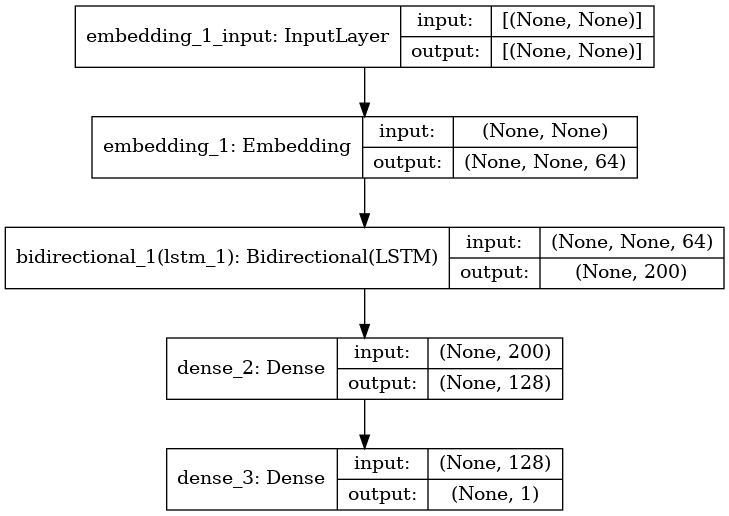

In [48]:
# construct model
BATCH_SIZE = 64

from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1,64))
model.add(Bidirectional(LSTM(100, dropout=0,recurrent_dropout=0)))
model.add(Dense(128, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam","binary_crossentropy",metrics=["accuracy"])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
# Used for preventing ovefitting
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

In [51]:
history = model.fit(X_train_seq_padded, y_train,batch_size=BATCH_SIZE,epochs=15,
                    validation_data=(X_test_seq_padded, y_test),callbacks=[early_stop])

Epoch 1/15
1182/1182 [==============================] - 15s 13ms/step - loss: 0.2848 - accuracy: 0.8840 - val_loss: 0.3632 - val_accuracy: 0.8530
Epoch 2/15
1182/1182 [==============================] - 14s 12ms/step - loss: 0.1893 - accuracy: 0.9268 - val_loss: 0.3866 - val_accuracy: 0.8427
Epoch 3/15
1182/1182 [==============================] - 15s 12ms/step - loss: 0.1265 - accuracy: 0.9528 - val_loss: 0.5014 - val_accuracy: 0.8350
Epoch 4/15
1182/1182 [==============================] - 14s 12ms/step - loss: 0.0847 - accuracy: 0.9695 - val_loss: 0.6014 - val_accuracy: 0.8242
Epoch 5/15
1182/1182 [==============================] - 15s 13ms/step - loss: 0.0533 - accuracy: 0.9808 - val_loss: 0.7092 - val_accuracy: 0.8258
Epoch 6/15
1182/1182 [==============================] - 14s 12ms/step - loss: 0.0373 - accuracy: 0.9872 - val_loss: 0.7603 - val_accuracy: 0.8237
Epoch 00006: early stopping


In [52]:
from sklearn.metrics import roc_auc_score
pred_train = model.predict(X_train_seq_padded)
pred_test = model.predict(X_test_seq_padded)
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(y_train, pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(y_test, pred_test)))

LSTM Recurrent Neural Network baseline: 0.9997381147416868
LSTM Recurrent Neural Network: 0.8951004819384993


In [53]:
model.evaluate(X_test_seq_padded, y_test)

788/788 [==============================] - 3s 4ms/step - loss: 0.7603 - accuracy: 0.8237


[0.7602547407150269, 0.8237301707267761]

Text(0.5, 1.0, 'Training and Validation Accuracy')

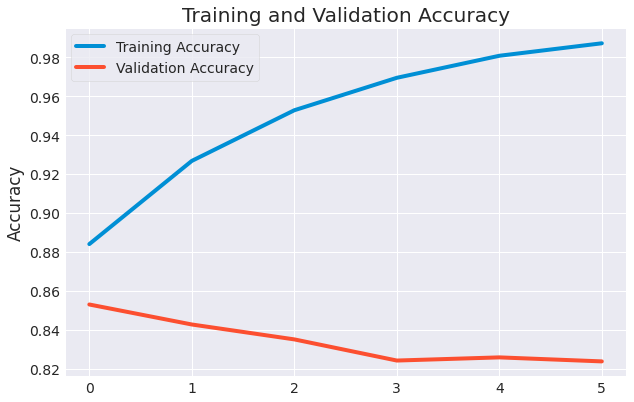

In [54]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

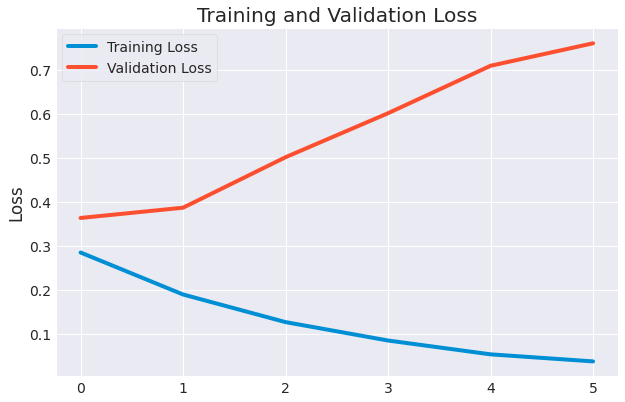

In [55]:
plt.figure(figsize=(9,6))
plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

* Since roc_auc_score of LSTM is best among all the models we trained, so **Bidirectional LSTM is the best model** among all the other ones which we have trained.